# Lec 2

## Generate data

<ipython-input-1-e10baa71e966>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


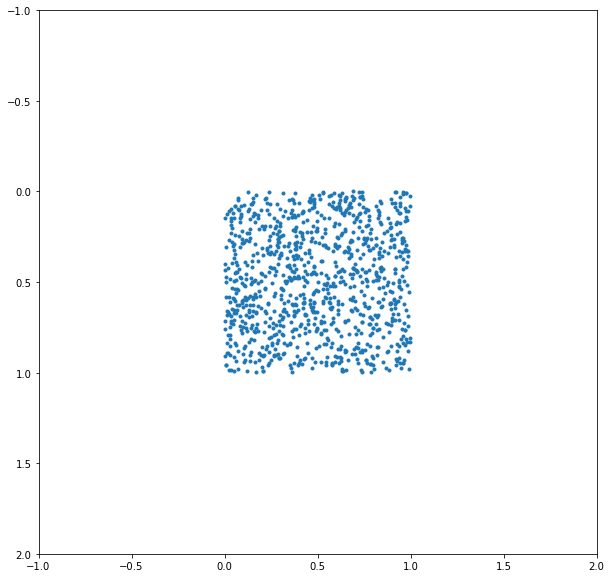

In [1]:
from random import Random
SEED = 5
random_gen = Random(x = SEED)
lst_x, lst_y = [], []
def generate_pnts(N = 1000):
    for _ in range(N):
        lst_x.append(random_gen.uniform(a=0, b=1))
    for _ in range(N):
        lst_y.append(random_gen.uniform(a=0, b=1))
    return lst_x, lst_y
data_x, data_y = generate_pnts()

from matplotlib.pyplot import figure
fig = figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x=data_x, y=data_y, marker = ".")
ax.set_xlim(left = -1, right = 2)
ax.set_ylim(top = -1, bottom = 2)

fig.show()

## Evaluate lose

In [19]:
from math import sqrt
def loss(x_p, y_p):
    return (1/len(data_x)) * sum(
    [sqrt((x_i - x_p) ** 2 + (y_i - y_p) ** 2) 
     for x_i, y_i in zip(data_x, data_y)]
    )

#we created a list of order n unneccesarrily, all what we need to do is running sum
#unefficient for space

## Visualize loss

In [20]:
STEP = 0.01
MESH_SIZE = 300
x_mesh = [-1 + i * STEP for i in range (MESH_SIZE)]
y_mesh = [-1 + i * STEP for i in range (MESH_SIZE)]
loss_mesh = [[loss(x_curr, y_curr) for x_curr in x_mesh] 
            for y_curr in y_mesh]

#very expensive operation

<ipython-input-21-38c0024d9ffe>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


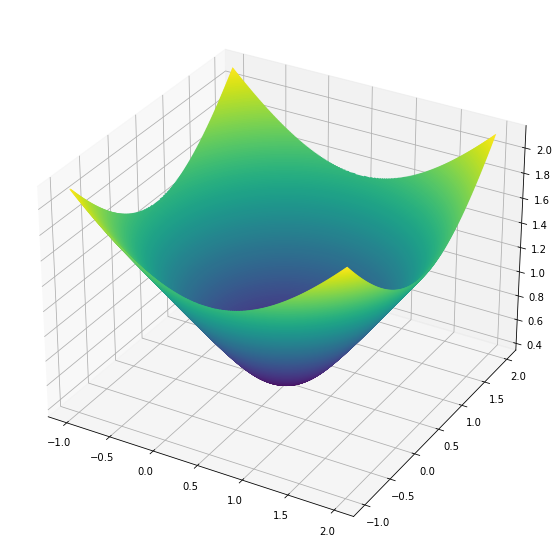

In [21]:
fig = figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection = "3d")
ax.contour(x_mesh, y_mesh, loss_mesh, levels = 500)
# ax.view_init(elev = 90)
fig.show()

## Numerical conceptualization of derivatives

0.4827431534688781 0.49004466505030875


<ipython-input-22-65d6d23648af>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


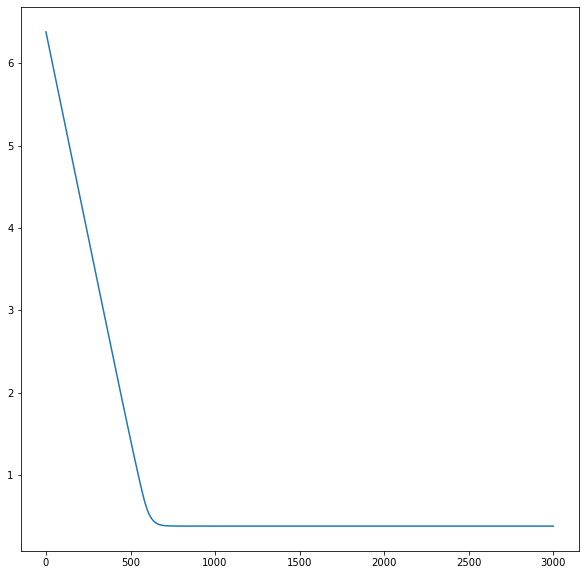

In [22]:
x_p, y_p = 5, 5      #initialize the solution to some arbitrary value

EPOCHS = 3000
H = 0.001
DELTA = 0.01
epoch_losses = []

for _ in range(EPOCHS):              #revisiting the whole data Epochs many times
    epoch_losses.append(loss(x_p, y_p))
    dloss_dx = (loss(x_p + H, y_p) - loss(x_p, y_p)) / H     #calc partial derivatives
    dloss_dy = (loss(x_p, y_p + H) - loss(x_p, y_p)) / H
    x_p -= DELTA * dloss_dx                         #update my solution by going against gradient
    y_p -= DELTA * dloss_dy
    
fig = figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(epoch_losses)
fig.show()
print(x_p, y_p)

# Lec 3
# Closed form evaluation of the gradient

In [16]:
# running sum for space efficiency instead of creating a list of N elements and sum them (as in calculating loss)
# another more efficient way to calculate gradient

def calc_grad(x_p, y_p):
    sum_x, sum_y = 0., 0.
    for x_i, y_i in zip(data_x, data_y):
        inv_sqrt = ((x_i - x_p) ** 2 + (y_i - y_p) ** 2) ** (-0.5)          #common between dloss_dx & dloss_dy
        sum_x += inv_sqrt * (x_i - x_p)
        sum_y += inv_sqrt * (y_i - y_p)
    return - sum_x / len(data_x), - sum_y / len(data_y)

H = 0.0001
x_p, y_p = 0.5, 0.5
print(f"closed form: {calc_grad(x_p, y_p)}")
dloss_dx = (loss(x_p + H, y_p) - loss(x_p, y_p)) / H     #calc partial derivatives
dloss_dy = (loss(x_p, y_p + H) - loss(x_p, y_p)) / H
print(f"original definition: {dloss_dx}, {dloss_dy}")

closed form: (0.02828649742364953, 0.016598934616586503)
original definition: 0.028393692923511793, 0.016741513965135013


0.48325981135643126 0.49056084025865876


<ipython-input-17-0e1e2a62d15d>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


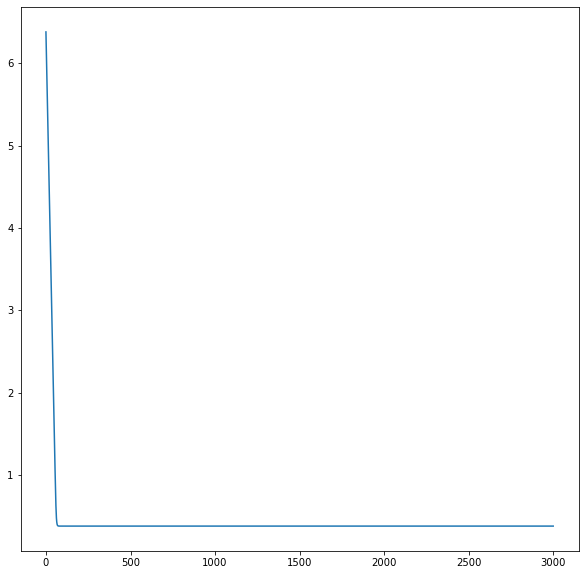

In [17]:
x_p, y_p = 5, 5
EPOCHS = 3000
DELTA = 0.1
epoch_lossess = []
for _ in range (EPOCHS):
    epoch_lossess.append(loss(x_p, y_p))
    partial_loss_partial_x, partial_loss_partial_y = calc_grad(x_p, y_p)
    x_p -= DELTA * partial_loss_partial_x
    y_p -= DELTA * partial_loss_partial_y
    
fig = figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(epoch_lossess)
fig.show()
print(x_p, y_p)

# Lec4 
# Stochastic Gradient Descent

In [13]:
#we needed to iterate over all data to calculate only 1 update to calculate the gradient contributed by every single point
from random import Random
from math import ceil, sqrt

SEED = 5
def generate_pnts(N=1000):
    lst_x, lst_y = [], []
    for _ in range(N):
        lst_x.append(random_gen.uniform(a=0, b=1))
    for _ in range(N):
        lst_y.append(random_gen.uniform(a=0, b=1))
    return lst_x, lst_y

def calc_grad(x_p, y_p, batch_x, batch_y):
    sum_x, sum_y = 0, 0
    for x_i, y_i in zip(batch_x, batch_y):
        inv_sqrt = ((x_i - x_p) ** 2 + (y_i - y_p) ** 2) ** (-0.5)
        sum_x += inv_sqrt * (x_i - x_p)
        sum_y += inv_sqrt * (y_i - y_p)
    return -sum_x / len(batch_x), -sum_y / len(batch_x)

def loss(x_p, y_p, batch_x, batch_y):
    return 1/len(batch_x) * sum(
        [ sqrt((x_i -x_p) ** 2 + (y_i - y_p) **2)
         for x_i, y_i in zip(batch_x, batch_y)
        ])

data_x, data_y = generate_pnts()
EPOCHS = 100                  #number of times to visit the whole dataset
sampler = Random(x = SEED)
x_p_sgd, y_p_sgd = 0.3, 0.3
x_p_gd, y_p_gd = 0.3, 0.3
indices = [i for i in range(len(data_x))]
BATCH_SZ = 4                  #in sgd, num of points contributing to gradient estimate in one update
N = len(data_x)
NUM_BATCHES = ceil(N / BATCH_SZ)
DELTA = 1e-2
losses_sgd, losses_gd = [], []

for _ in range(EPOCHS):                         #كل مرة في الابوكس بلف على باتش باتش من الباتشات
    #SGD
    sampler.shuffle(indices)
    for batch_ind in range(NUM_BATCHES):
        batch_indices = indices[batch_ind * BATCH_SZ : (batch_ind + 1) * BATCH_SZ]
        batch_x = [data_x[i] for i in batch_indices]
        batch_y = [data_y[i] for i in batch_indices]
        grad_x_sgd, grad_y_sgd = calc_grad(x_p_sgd, y_p_sgd, batch_x, batch_y)
        x_p_sgd -= DELTA * grad_x_sgd
        y_p_sgd -= DELTA * grad_y_sgd
        losses_sgd.append(loss(x_p_sgd, y_p_sgd, data_x, data_y))
        
    #GD    
    grad_x_gd, grad_y_gd = calc_grad(x_p_gd, y_p_gd, data_x, data_y)
    x_p_gd -= DELTA * grad_x_gd
    y_p_gd -= DELTA * grad_y_gd
    losses_gd.append(loss(x_p_gd, y_p_gd, data_x, data_y))


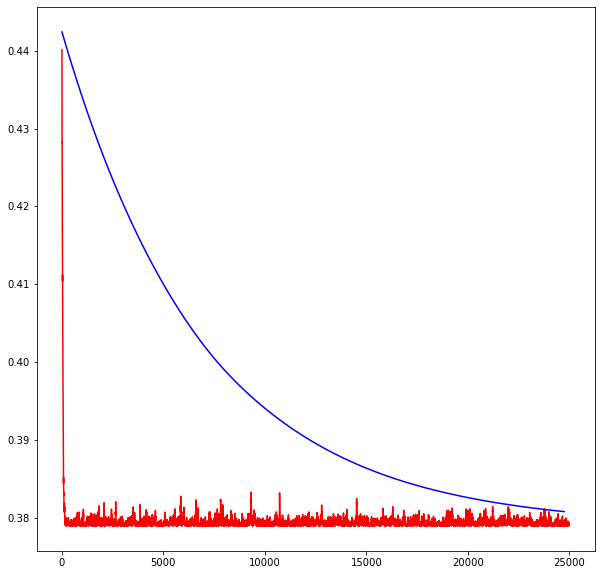

In [16]:
from matplotlib.pyplot import figure
fig = figure(figsize= (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(losses_sgd, "r")
ax.plot([i * NUM_BATCHES for i in range(len(losses_gd))], losses_gd, "b")

# Lec 5 pytorch

In [77]:
from random import Random
from math import ceil, sqrt
from time import monotonic

SEED = 5
random_gen = Random(x = SEED)
lst_x, lst_y = [], []
def generate_pnts(N = 1000):
    for _ in range(N):
        lst_x.append(random_gen.uniform(a=0, b=1))
    for _ in range(N):
        lst_y.append(random_gen.uniform(a=0, b=1))
    return lst_x, lst_y

def loss(x_p, y_p, batch_x, batch_y):
    return 1/len(batch_x) * sum(
        [ sqrt((x_i -x_p) ** 2 + (y_i - y_p) **2)
         for x_i, y_i in zip(batch_x, batch_y)
        ])

#Visualization
data_x, data_y = generate_pnts()
STEP = 0.01
MESH_SIZE = 300
x_mesh = [-1 + i * STEP for i in range (MESH_SIZE)]
y_mesh = [-1 + i * STEP for i in range (MESH_SIZE)]
start_time = monotonic()
loss_mesh = [[loss(x_curr, y_curr, data_x, data_y) for x_curr in x_mesh] 
            for y_curr in y_mesh]
print(f"Time = {(monotonic() - start_time) * 1000 :0.2f} ms")

Time = 43969.00 ms


In [153]:
import torch

data_torch = torch.tensor([data_x, data_y])
print(f"Shape {data_torch.shape}")
print (f"ptr for data_torch {data_torch.storage().data_ptr()}")
print (f"before transpose {data_torch.stride(0), data_torch.stride(1)}")

data_torch = data_torch.t()
print (f"Shape after transposing {data_torch.shape}")
print (f"ptr for data_torch after transposing {data_torch.storage().data_ptr()}")
print (f"after transpose {data_torch.stride(0), data_torch.stride(1)}")

# broadcasting
data_torch = data_torch.broadcast_to(size = (100, 1000, 2))      #repeat the data 100 times through the 0 dim
print (f"Shape after broadcating {data_torch.shape}")
print (f"ptr for data_torch after broadcating {data_torch.storage().data_ptr()}")
print (f"after broadcasting {data_torch.stride(0)}, {data_torch.stride(1)}, {data_torch.stride(2)}")

Shape torch.Size([2, 1000])
ptr for data_torch 2201588381888
before transpose (1000, 1)
Shape after transposing torch.Size([1000, 2])
ptr for data_torch after transposing 2201588381888
after transpose (1, 1000)
Shape after broadcating torch.Size([100, 1000, 2])
ptr for data_torch after broadcating 2201588381888
after broadcasting 0, 1, 1000


<ipython-input-153-ae29a559990a>:5: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print (f"ptr for data_torch {data_torch.storage().data_ptr()}")
<ipython-input-153-ae29a559990a>:10: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print (f"ptr for data_torch after transposing {data_torch.storage().data_ptr()}")
<ipython-input-153-ae29a559990a>:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are usi

In [79]:
x_p, y_p = 5., 5.
old_loss = loss(x_p, y_p, data_x, data_y)
print(f"old loss {old_loss}")

old loss 6.382888159785493


In [80]:
import torch

data_torch = torch.tensor([data_x, data_y])
data_torch = data_torch.t()
pnt = torch.tensor([5., 5.])
print(pnt.shape)
res = data_torch - pnt
res = res ** 2
res = res.sum(dim = 1)
res = torch.sqrt(res)
# print(res.shape)
res = res.sum(dim = 0) / data_torch.shape[0]
# print(res.shape)
print(res)

torch.Size([2])
tensor(6.3829)


In [81]:
import torch
from time import monotonic

torch_loss_fn = lambda pnt, data: torch.sqrt(((data - pnt) ** 2).sum(dim = 1)).sum(dim = 0) / data.shape[0]
torch_data = torch.tensor([data_x, data_y]).t()
print(torch_data.shape)

STEP = 0.01
MESH_SIZE = 300
x_mesh = [-1 + i * STEP for i in range(MESH_SIZE)]
y_mesh = [-1 + i * STEP for i in range(MESH_SIZE)]

start_time = monotonic()
loss_mesh = [[torch_loss_fn(torch.tensor([x_curr, y_curr]), torch_data) for x_curr in x_mesh]
            for y_curr in y_mesh]
print ((monotonic() - start_time) * 1000)

torch.Size([1000, 2])
4641.00000000326


In [82]:
# to get rid of for loop
#func. accepts points not point by point
torch_loss_fn_faster = lambda pnt, data: torch.sqrt(((pnt - data.repeat((pnt.shape[0], 1, 1)).view(-1, pnt.shape[0], 2))\
                                                    ** 2).\
                                                   sum(dim = -1)).sum(dim = 0)/data.shape[0]
#operation occurs in GPU instead of CPU
torch_data = torch.tensor([data_x, data_y]).t()

#pnts is all mesh points without for loop
x_0 = torch.linspace(-1, 2, 300).repeat(1, 300).t()
x_1 = torch.linspace(-1, 2, 300).repeat(300, 1).t().reshape(-1, 1)

#transfer pnts to cuda(API of NIVIDIA GPUs)
pnts= torch.hstack((x_0, x_1))

start_time = monotonic()
res = torch_loss_fn_faster(pnts, torch_data)
print ((monotonic() - start_time) * 1000)

1375.0


# Problem statement
#### Given th two_moon dataset, build a classifier capable of categorizing unseen examples as neither belonging to one of the moons


## Generate Data

In [143]:
from sklearn.datasets import make_moons
from math import floor

N = 1000
NOISE = 0.1
train_percent = 0.8

x, y = make_moons(n_samples = N, shuffle = True, noise = NOISE, random_state = 5)
x_train, y_train = x[:floor(train_percent * N), : ], y[:floor(train_percent * N)]
x_valid, y_valid = x[floor(train_percent * N) : , : ], y[floor(train_percent * N) : ]
print (x_valid.shape, y_valid.shape)

(200, 2) (200,)


## Visualize data

<ipython-input-144-292e0ca542ca>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


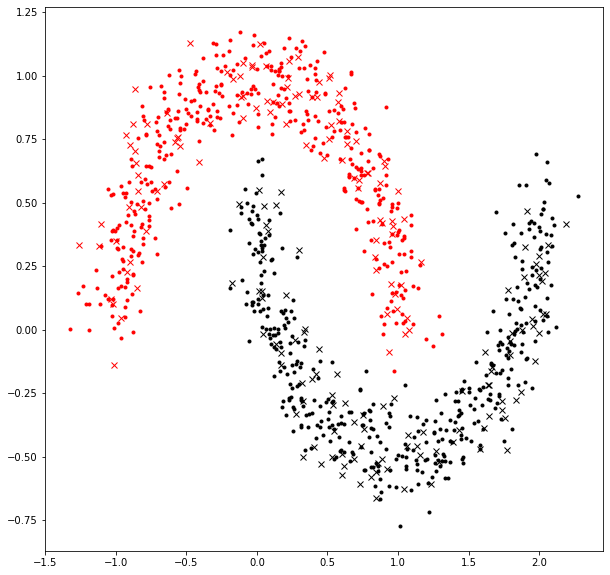

In [144]:
from matplotlib.pyplot import figure
import numpy as np

fig = figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
train_one_indices = np.argwhere(y_train  == 1)
train_zero_indices = np.argwhere(y_train == 0)
ax.plot(x_train[train_one_indices, 0], x_train[train_one_indices, 1], 'k.')
ax.plot(x_train[train_zero_indices, 0], x_train[train_zero_indices, 1], 'r.')

valid_one_indices = np.argwhere(y_valid == 1)
valid_zero_indices = np.argwhere(y_valid == 0)
ax.plot(x_valid[valid_one_indices, 0], x_valid[valid_one_indices, 1], 'kx')
ax.plot(x_valid[valid_zero_indices, 0], x_valid[valid_zero_indices, 1], 'rx')
# ax.plot(x_valid[:, 0], x_valid[:, 1], 'kx')
fig.show()

## Encode targets and move to pytorch

In [145]:
# pytorch has gradients(we will not calculate gradients) but numpy not
import torch

x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
x_valid, y_valid = torch.tensor(x_valid), torch.tensor(y_valid)
# print(y_train[:], y_train.shape)

y_train = torch.nn.functional.one_hot(y_train, num_classes = 2)
y_valid = torch.nn.functional.one_hot(y_valid, num_classes = 2)

# print(f"after {y_train[:10,:]}, {y_train.shape}")

## Forward path

In [146]:
torch.manual_seed(5)

w = torch.randn(size = (2, 2))
w = w.to(torch.float64)
w.requires_grad = True
w.retain_grad()

b = torch.randn(size = (1, 2))
b = b.to(torch.float64)
b.requires_grad = True
b.retain_grad()

In [147]:
def predict(x):
    a = x @ w.t() + b
    return torch.softmax(a, dim = 1)

In [148]:
# y_hat = predict(torch.tensor([[1., 1.], [2., 2.]]))
# y_hat

## loss function

In [149]:
def loss_fn(x, y):
    y_hat = predict(x)
    return torch.mean(-(y * torch.log(y_hat)).sum(dim = 1))

In [150]:
# l = loss_fn(torch.tensor([[1., 1.], [2., 2.]]), y = torch.tensor([[0, 1], [1, 0]]))
# print(l)

## Optimization loop

In [151]:
EPOCHS = 1000
DELTA = 0.1
train_loss, valid_loss = [], []

for _ in range(EPOCHS):
    curr_train_loss = loss_fn(x_train, y_train)
    curr_train_loss.backward()
    train_loss.append(curr_train_loss.data)
    with torch.no_grad():
        curr_valid_loss = loss_fn(x_valid, y_valid)
        valid_loss.append(curr_valid_loss.data)
        w -= DELTA * w.grad.data
        b -= DELTA * b.grad.data
        w.grad.zero_()             #inplace
        b.grad.zero_()

## Visualization

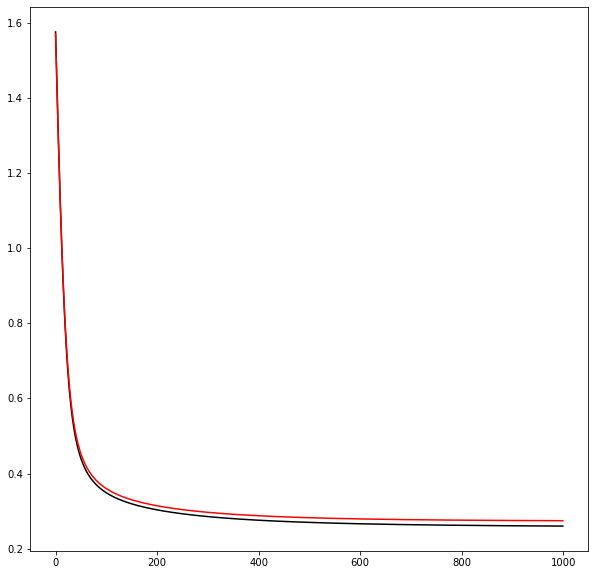

In [152]:
fig = figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_loss, 'k')
ax.plot(valid_loss, 'r')

# Lec 7&8

In [219]:
from random import Random
from math import ceil, sqrt

SEED = 5
random_gen = Random(x= SEED)
def generate_pnts(N=1000):
    lst_x, lst_y = [], []
    for _ in range(N):
        lst_x.append(random_gen.uniform(a=0, b=1))
    for _ in range(N):
        lst_y.append(random_gen.uniform(a=0, b=1))
    return lst_x, lst_y

def calc_grad(x_p, y_p, batch_x, batch_y):
    sum_x, sum_y = 0, 0
    for x_i, y_i in zip(batch_x, batch_y):
        inv_sqrt = ((x_i - x_p) ** 2 + (y_i - y_p) ** 2) ** (-0.5)
        sum_x += inv_sqrt * (x_i - x_p)
        sum_y += inv_sqrt * (y_i - y_p)
    return -sum_x / len(batch_x), -sum_y / len(batch_x)

def loss(x_p, y_p, batch_x, batch_y):
    return 1/len(batch_x) * sum(
        [ sqrt((x_i -x_p) ** 2 + (y_i - y_p) **2)
         for x_i, y_i in zip(batch_x, batch_y)
        ])

data_x, data_y = generate_pnts(N = 1)
x_p, y_p = 0.3, 0.3
grad_x, grad_y = calc_grad(x_p, y_p, data_x, data_y)
curr_loss = loss(x_p, y_p, data_x, data_y)
print(f"Closed form: gradient for x_p {grad_x}, gradient for y_p {grad_y}")
print(f"Closed form: loss {curr_loss}")

Closed form: gradient for x_p -0.5900849147094943, gradient for y_p -0.8073411877467226
Closed form: loss 0.5472122517293468


# Pytorch as an exmple of Autograd engines

In [197]:
import torch
pnt = torch.tensor([0.3, 0.3])
pnt.requires_grad = True
pnt.retain_grad()

data_x, data_y = generate_pnts()
data = torch.tensor([data_x, data_y])
data = data.t()
print(data.shape, pnt.shape)

for i in range(1):
    print(f"iteration {i}")
    loss_torch = torch.mean(torch.sqrt(((data - pnt) ** 2).sum(dim = 1)))
    print(f"torchloss {loss_torch}")
    loss_torch.backward()
    print(f"grad {pnt.grad.data}")
    pnt.grad.zero_()
    print(f"torch grad after zeroing {pnt.grad.data}")


torch.Size([1000, 2]) torch.Size([2])
iteration 0
torchloss 0.4512902796268463
grad tensor([-0.3037, -0.3339])
torch grad after zeroing tensor([0., 0.])


# Building Autograd from scratch

In [259]:
class comp_node:
    def __init__(self, val, children = [], op = "assign"):
        self.val = val
        self.children = children
        self.grad = 0
        self.op = op
        self.bacward_prop = lambda : None
        
    def __to_comp_node(self, obj):
        if not isinstance(obj, comp_node):
            return comp_node(val = obj)
        else:
            return obj
        
    def __sub__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val = self.val - other.val, children = [self, other], op = "sub")
        def _backward_prop():
            self.grad = out.grad * 1
            other.grad = out.grad * -1
        out.bacward_prop = _backward_prop
        return out
    
    # self is the right operand of the subtraction operation and other is the left operand
    def __rsub__(self, other):
        other = self.__to_comp_node(other)
        return other - self
    
    def __add__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val = self.val + other.val, children = [self, other], op = "add")
        def _backward_prop():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out.bacward_prop = _backward_prop
        return out
    
    # self is the right operand of the subtraction operation and other is the left operand
    def __radd__(self, other):
        other = self.__to_comp_node(other)
        return other + self
    
    def __mul__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val = self.val * other.val, children =[self, other], op = "mul")
        def _backward_prop():
            self.grad = out.grad * other.val
            other.grad = out.grad * self.val
        out.bacward_prop = _backward_prop
        return out
    
    def __rmul__(self, other):
        other = self.__to_comp_node(other)
        return other * self
    
    def __pow__(self, exponent):
        if not isinstance(exponent, (int, float)):
            raise ValueError("Unsupported types")
        out = comp_node(val = self.val ** exponent, children = [self], op = f"power {exponent}")
        def _backward_prop():
            self.grad += out.grad * (exponent * self.val ** (exponent - 1))
        out.bacward_prop = _backward_prop
        return out
    
    def __eq__(self, other):
        return self.val == other.val
    def __repr__(self):
        return f"op: {self.op} | val: {self.val:.4f} | children: {len(self.children)} | grad: {self.grad}"
    


In [260]:
assert comp_node(val = 5).val == 5, "Assignment failed"
assert (comp_node(val = 5) - comp_node(val = 3)).val == 2 
assert (comp_node(val = 5) - 3).val == 2
assert (3 - comp_node(val = 5)).val == -2
assert(comp_node(val = 5) ** 2).val == 25
assert(comp_node(val = 5) ** 2) == comp_node(val = 25)
assert (comp_node(val = 5) + comp_node(val = 3)).val == 8
assert (comp_node(val = 5) + 3).val == 8
assert (3 + comp_node(val = 5)).val == 8
assert (comp_node(val = 5) * 3).val == 15
assert (3 * comp_node(val = 5)).val == 15

## Forward path

In [261]:
SEED = 5
random_gen = Random(x= SEED)
def generate_pnts(N=1000):
    lst_x, lst_y = [], []
    for _ in range(N):
        lst_x.append(random_gen.uniform(a=0, b=1))
    for _ in range(N):
        lst_y.append(random_gen.uniform(a=0, b=1))
    return lst_x, lst_y


data_x, data_y = generate_pnts(N = 1)
x_p, y_p = comp_node(val = 0.3), comp_node(val = 0.3)

def loss_graph(x_p, y_p, data_x, data_y):
    I_x, I_y = x_p - data_x, y_p - data_y
    g_x, g_y = I_x ** 2, I_y ** 2
    M = g_x + g_y
    l = M ** 0.5
    return l, [l, M, g_x, g_y, I_x, I_y, x_p, y_p]

l, rev_topo_order = loss_graph(x_p, y_p, data_x[0], data_y[0])
rev_topo_order[0].grad = 1

for i, node in enumerate(rev_topo_order):
    print(i, node)
    node.bacward_prop()

0 op: power 0.5 | val: 0.5472 | children: 1 | grad: 1
1 op: add | val: 0.2994 | children: 2 | grad: 0.9137222319490423
2 op: power 2 | val: 0.1043 | children: 1 | grad: 0.9137222319490423
3 op: power 2 | val: 0.1952 | children: 1 | grad: 0.9137222319490423
4 op: sub | val: -0.3229 | children: 2 | grad: -0.5900849147094943
5 op: sub | val: -0.4418 | children: 2 | grad: -0.8073411877467226
6 op: assign | val: 0.3000 | children: 0 | grad: -0.5900849147094943
7 op: assign | val: 0.3000 | children: 0 | grad: -0.8073411877467226


# Lec 9

In [262]:
graph_1_vertices = set(list(range(8)))
graph_1_edges = {
    0: [1, 4],
    1: [0, 5],
    2: [5, 6],
    3: [7],
    4: [0],
    5: [1, 2, 6],
    6: [2, 5, 7],
    7: [3, 6],
}

graph_2_vertices = set(list(range(6)))
graph_2_edges = {
    0: [1, 3],
    1: [4],
    2: [4, 5],
    3: [1],
    4: [3],
    5: [5],
}
from graphviz import Digraph
def draw_graph(vertices, edges):
    dot = Digraph(format = "svg")
    for v in vertices:
        dot.node(name = str(v), label = f"{v}")
    for k, v in edges.items():
        for curr_v in v:
            dot.egde(str(k), str(curr_v))
    return dot
draw_graph(graph_1_vertices, graph_1_edges)

ModuleNotFoundError: No module named 'graphviz'

In [264]:
from collections import deque
graph_vertices = graph_1_vertices
graph_edges = graph_1_edges

s = 1
q = deque()
visited = set()

q.append(s)
visited.add(s)

while(len(q) > 0):
    curr_vertex = q.popleft()
    
    print(f"visited: {curr_vertex}")
    for neighbour in graph_edges[curr_vertex]:
        if neighbour not in visited:
            q.append(neighbour)
            visited.add(neighbour)

visited: 1
visited: 0
visited: 5
visited: 4
visited: 2
visited: 6
visited: 7
visited: 3
